In [1]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve,confusion_matrix, auc,roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from datetime import datetime, date, time
from functools import reduce
import catboost
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('mode.chained_assignment',  None)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',10)
old_settings = np.seterr(all='print')

In [2]:
def CF_IBCF1(nan_dict, df2, df):
    '''아이템협업기반 결측치를 채우는 함수 n=3, 
       nan_dict = 결측치 위치를 담는 딕셔너리
       df2 = 전치행렬 만들기 위해 임위로 결측치를 채운 데이터프레임
    '''

    #예측메트릭스 생성
    df2=df2.drop(['Key'],axis=1)
    
    for c in df2.columns:
        #df2[c]=df2[c].fillna(0)
        df2[c]=df2[c].fillna(df2[c].mean())

    df_T = df2.transpose()

    from sklearn.metrics.pairwise import cosine_similarity
    item_sim = cosine_similarity(df_T, df_T)
    item_sim_df = pd.DataFrame(data=item_sim, index=df2.columns
                              ,columns=df2.columns)

    # 계산
    df_pred = np.zeros(df2.values.shape)
    for col in range(df2.values.shape[1]):
        top_n_items = [np.argsort(item_sim_df.values[:, col])[:-5:-1]]
        
        for row in range(df2.values.shape[0]):
            df_pred[row, col] = item_sim_df.values[col, :][top_n_items].dot(df2.values[row, :][top_n_items].T)
            
            # 분모가 0이되는 경우는 결측치 상태 유지
            if df_pred[row, col] == 0.0:
                df_pred[row, col] = np.nan  
            df_pred[row, col] /= np.sum(np.abs(item_sim_df.values[col, :][top_n_items]))    
   

    df_pred_matrix = pd.DataFrame(data=df_pred, index= df2.index,
                                    columns = df2.columns)
    
    df_pred_matrix.insert(loc=250,column='Key',value=df['Key'])
    
    for key, value in nan_dict.items():
        if value:
            for i in range(len(value)):
                df[key][value[i]] = df_pred_matrix[key][value[i]]
    return df

# imputation

In [3]:
merge_df = pd.read_csv('merge_df.csv')

In [4]:
nan_dict = {}
i=0
nan_list=[]
for c in merge_df.columns:
    nan_list = merge_df[str(c)].isna() 
    arr = []
    for j in range(len(merge_df)):
        if nan_list[j]:
            arr.append(j)
    nan_dict[c] = arr
    i=i+1


merge_df = CF_IBCF1(nan_dict,merge_df,merge_df)

In [5]:
pd.set_option('display.max_rows',None)
merge_df.isnull().sum()

소요시간                            0
RT_A3                           0
RT_A4                           0
RT_A5                           0
RT_A8                           0
RT_A10                          0
소요시간.1                          0
RT_B1                           0
RT_B2                           0
RT_B3                           0
RT_B5                           0
RT_B9                           0
RT_A_median                     0
RT_A_sd                         0
RT_A_min                        0
RT_A_max                        0
RT_B_sum                        0
RT_B_median                     0
RT_B_sd                         0
RT_B_min                        0
RT_B_max                        0
정답수.2                           0
cal10.1                         0
RT_cal1                         0
RT_cal2                         0
RT_cal3                         0
RT_cal4                         0
RT_cal6                         0
RT_cal7                         0
RT_cal8       

In [6]:
merge_df.shape

(289, 252)

# CatBoostClassifier

In [7]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=5,random_state=seed,n_repeats=4)

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

sc = StandardScaler()
x_df = pd.DataFrame(sc.fit_transform(x_df), columns=x_df.columns)

for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]

    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)

    #SMOTE로 타겟의 분포를 균등하게 조절
    smote = SMOTE(random_state=42)
    x_train_sk, y_train_sk = smote.fit_resample(x_train_sk, y_train_sk)
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )
    
    
    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)

    model.fit(D_train, eval_set=D_test, verbose=False)

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print(j,'번째')
    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)

 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
0 번째
Youden index threshold :  0.48578131991677537
roc_auc_score :  0.5354166666666667
acc :  0.7758620689655172
sensitivity :  0.3
specificity :  0.875
pr_auc :  0.28538105996667085 

[[42  6]
 [ 7  3]]
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
1 번째
Youden index threshold :  0.2352662866778211
roc_auc_score :  0.8458333333333333
acc :  0.8448275862068966
sensitivity :  0.8
specificity :  0.8541666666666666
pr_auc :  0.4252579110421157 

[[41  7]
 [ 2  8]]
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
2 번째
Youden index threshold :  0.4950033861753725
roc_auc_score :  0.56875
acc :  0.6896551724137931
sensitivity :  0.5
specificity :  0.7291666666666666
pr_auc :  0.19884725809939133 

[[35 13]
 [ 5  5]]
 변화된 값의 분포 :
 0    153
1    153
Name: cutoff, dtype: int64
3 번째
Youden index threshold :  0.38671871006687647
roc_auc_score :  0.6258503401360545
acc :  0.8275862068965517
sensitivity :  0.4444444444

In [8]:
print('proba_score',np.mean(proba_score))
print('re_score',np.mean(re_score))
print('specifi_score',np.mean(specifi_score))
proba_score

proba_score 0.6668232709750568
re_score 0.7027777777777778
specifi_score 0.6958971088435375


[0.5354166666666667,
 0.8458333333333333,
 0.56875,
 0.6258503401360545,
 0.6018518518518519,
 0.5979166666666667,
 0.6979166666666666,
 0.6104166666666667,
 0.6938775510204082,
 0.7939814814814814,
 0.7854166666666667,
 0.4770833333333333,
 0.6125,
 0.6031746031746033,
 0.6643518518518519,
 0.625,
 0.6812499999999999,
 0.78125,
 0.6712018140589568,
 0.8634259259259259]

In [9]:
TN_ls = []
FP_ls = []
FN_ls = []
TP_ls = []

for i in range(20):
    TN_ls.append(cm1_score[i][0][0]) # TN
    FP_ls.append(cm1_score[i][0][1]) # FP
    FN_ls.append(cm1_score[i][1][0]) # FN
    TP_ls.append(cm1_score[i][1][1]) # TP

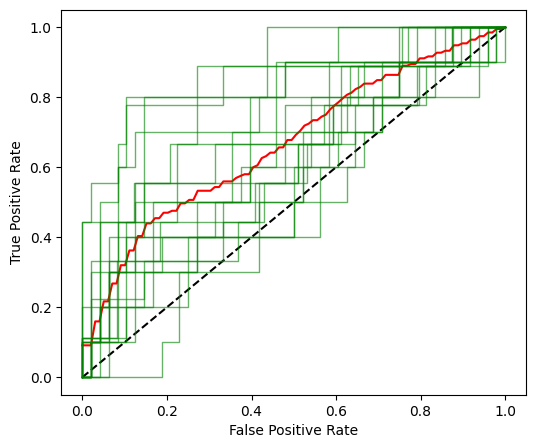

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

mean_tpr = np.mean(tprs_ls, axis=0)
plt.plot(mean_fpr, mean_tpr, color='red')

for i,j in zip(curve_fprs, curve_tprs):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.6, label=None)

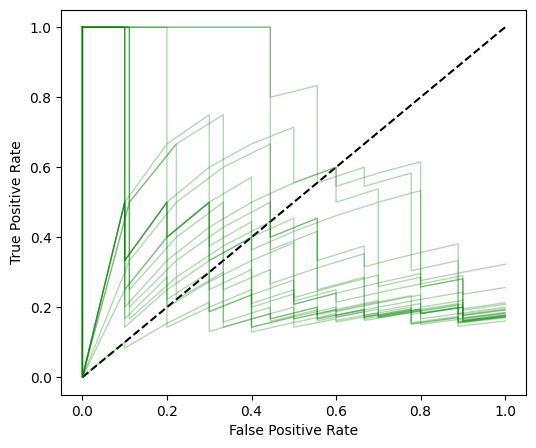

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i,j in zip(curve_rec, curve_pre):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.3, label=None)

# 1010

In [12]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=10,random_state=seed,n_repeats=10)

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

sc = StandardScaler()
x_df = pd.DataFrame(sc.fit_transform(x_df), columns=x_df.columns)

for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]

    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)

    #SMOTE로 타겟의 분포를 균등하게 조절
    smote = SMOTE(random_state=42)
    x_train_sk, y_train_sk = smote.fit_resample(x_train_sk, y_train_sk)
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )
    
    
    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)

    model.fit(D_train, eval_set=D_test, verbose=False)

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print(j,'번째')
    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)

 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
0 번째
Youden index threshold :  0.08443345345146018
roc_auc_score :  0.6416666666666666
acc :  0.5862068965517241
sensitivity :  1.0
specificity :  0.5
pr_auc :  0.36750200779612546 

[[12 12]
 [ 0  5]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
1 번째
Youden index threshold :  0.4858040380642036
roc_auc_score :  0.6166666666666667
acc :  0.7241379310344828
sensitivity :  0.6
specificity :  0.75
pr_auc :  0.21890313390313387 

[[18  6]
 [ 2  3]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
2 번째
Youden index threshold :  0.26762576011786854
roc_auc_score :  0.9166666666666667
acc :  0.8620689655172413
sensitivity :  1.0
specificity :  0.8333333333333334
pr_auc :  0.6255555555555556 

[[20  4]
 [ 0  5]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
3 번째
Youden index threshold :  0.24770623334208644
roc_auc_score :  0.8833333333333333
acc :  0.7931034482758621
sensitivity :  1.0
specificity 

In [13]:
print('proba_score',np.mean(proba_score))
print('re_score',np.mean(re_score))
print('specifi_score',np.mean(specifi_score))
proba_score

proba_score 0.6875583333333334
re_score 0.7510000000000001
specifi_score 0.7405999999999999


[0.6416666666666666,
 0.6166666666666667,
 0.9166666666666667,
 0.8833333333333333,
 1.0,
 0.4166666666666667,
 0.8416666666666667,
 0.525,
 0.83,
 0.5104166666666667,
 0.55,
 0.7916666666666666,
 0.8416666666666667,
 0.7833333333333334,
 0.8499999999999999,
 0.6916666666666667,
 0.85,
 0.725,
 0.74,
 0.8958333333333334,
 0.5416666666666667,
 0.6583333333333334,
 0.6666666666666667,
 0.575,
 0.5916666666666667,
 0.775,
 0.8250000000000001,
 0.6583333333333334,
 0.48000000000000004,
 0.6770833333333333,
 0.7916666666666666,
 0.625,
 0.5583333333333333,
 0.7666666666666667,
 0.7666666666666667,
 0.675,
 0.625,
 0.6166666666666667,
 0.96,
 0.9479166666666666,
 0.5083333333333333,
 0.5833333333333334,
 0.8,
 0.5583333333333333,
 0.75,
 0.7,
 0.525,
 0.8500000000000001,
 0.69,
 0.5729166666666666,
 0.6666666666666666,
 0.475,
 0.7833333333333333,
 0.6166666666666667,
 0.43333333333333335,
 0.9083333333333333,
 0.5166666666666666,
 0.8333333333333333,
 0.95,
 0.75,
 0.5708333333333333,
 0.67

In [14]:
CF_item = pd.DataFrame()
CF_item['proba_score'] = proba_score
CF_item['re_score'] = re_score
CF_item['specifi_score'] = specifi_score 
CF_item.to_csv('CF_item_SMOTE_1010.csv',index=False)